### Investigate future prediction capacity of trained models
Evaluate the ability of trained models optimized for next timestep (i.e. 1 step ahead) prediction to generalize to predicting longer horizons (i.e. an arbitrary number of future timesteps).

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
from data._utils import load_Uzel2022, load_Skora2018
from models._main import get_model
from models._utils import *
from omegaconf import OmegaConf
from utils import DEVICE

In [2]:
# # Load a trained model from the config file (simpler)

# # load config
# config_path = "../logs/hydra/2023_06_12_10_05_30/config.yaml"
# config = OmegaConf.load(config_path)
# print("config:", OmegaConf.to_yaml(config), end="\n\n")

# # training params
# epoch = config.train.epochs
# seq_len = config.train.seq_len
# tau = config.train.tau_in
# smooth_data = config.globals.smooth_data

# # names
# model_name = config.model.type
# train_dataset_name = config.dataset.name

# # print info
# print(
#     "{} model was trained on dataset {} containing sequences of length "
#     "{} for {} epochs to predict {} timesteps into the future.".format(
#         model_name,
#         train_dataset_name,
#         seq_len,
#         epoch,
#         tau,
#     ),
#     end="\n\n",
# )

# # load the pretrained model
# model = get_model(config)
# model.eval()

In [3]:
# Load a trained model from the saved checkpoint (more complicated)

# load checkpoint
checkpoint_path = (
    "../logs/hydra/2023_06_12_23_26_25/checkpoints/200_epochs_48000_worms.pt"
)
checkpoint = torch.load(checkpoint_path, map_location=torch.device(DEVICE))

# Get checkpoint variables
# state dictionaries
model_state_dict = checkpoint["model_state_dict"]

# training params
epoch = checkpoint["epoch"]
seq_len = checkpoint["seq_len"]
tau = checkpoint["tau"]
smooth_data = checkpoint["smooth_data"]

# model instance params
input_size = checkpoint["input_size"]
hidden_size = checkpoint["hidden_size"]
num_layers = checkpoint["num_layers"]
loss_name = checkpoint["loss_name"]
fft_reg_param = checkpoint["fft_reg_param"]
l1_reg_param = checkpoint["l1_reg_param"]

# names
model_name = checkpoint["model_name"]
train_dataset_name = checkpoint["dataset_name"]

# print info
print(
    "{} model was trained on dataset {} containing sequences of length "
    "{} for {} epochs to predict {} timesteps into the future.".format(
        model_name,
        train_dataset_name,
        seq_len,
        epoch,
        tau,
    ),
    end="\n\n",
)

# Load the model checkpoint
model = eval(model_name)(
    input_size,
    hidden_size,
    num_layers,
    loss=loss_name,
    fft_reg_param=fft_reg_param,
    l1_reg_param=l1_reg_param,
)
model.load_state_dict(model_state_dict)
model.eval()

NetworkLSTM model was trained on dataset Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nichols2017_Skora2018 containing sequences of length 200 for 200 epochs to predict 1 timesteps into the future.



NetworkLSTM(
  (identity): Identity()
  (linear): Linear(in_features=1024, out_features=302, bias=True)
  (lstm): LSTM(302, 1024, batch_first=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [4]:
# Ideally evaluate the model on a test dataset that it was not trained on

# test_dataset = load_Uzel2022()  # dataset of multiple worms
test_dataset = load_Skora2018()  # dataset of multiple worms

# determine if the test dataset was seen during training
test_dataset_name = test_dataset["worm0"]["dataset"]
in_distribution = test_dataset_name in train_dataset_name
dataset_inclusion_str = int(not in_distribution) * "un" + "familiar"
print(
    "The (train) dataset(s) the model was trained on:", train_dataset_name, end="\n\n"
)
print("The (test) dataset(s) to make predictions on:", test_dataset_name, end="\n\n")
print("Was the test dataset seen during training?", "YES" if in_distribution else "NO")

The (train) dataset(s) the model was trained on: Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nichols2017_Skora2018

The (test) dataset(s) to make predictions on: Skora2018

Was the test dataset seen during training? YES


In [5]:
# Get values from the test dataset to use for prediciton and plots

named_neurons_mask = test_dataset["worm0"]["named_neurons_mask"]
if smooth_data:
    calcium_data = test_dataset["worm0"]["smooth_calcium_data"]
else:
    calcium_data = test_dataset["worm0"]["calcium_data"]
time_in_seconds = test_dataset["worm0"]["time_in_seconds"]
max_timesteps = test_dataset["worm0"]["max_timesteps"]
slot_to_named_neuron = test_dataset["worm0"]["slot_to_named_neuron"]

In [ ]:
# Investigate the model's ability to complete a sequence

context_len = 200
new_timesteps = 200
start_time_slice = range(0, context_len)
future_time_slice = range(context_len, context_len + new_timesteps)
complete_time_slice = range(0, context_len + new_timesteps)

input_ = calcium_data[start_time_slice, :] * named_neurons_mask
target = calcium_data[future_time_slice, :] * named_neurons_mask

# put on device
model = model.to(DEVICE)
input_ = input_.to(DEVICE)

output = model.generate(input_, new_timesteps, mask=named_neurons_mask).cpu().squeeze(0)

In [13]:
# Pick one of the labeled neurons in the test dataset to inspect

named_neuron_inds = torch.where(named_neurons_mask)[0].numpy()
nidx = np.random.choice(named_neuron_inds)  # pick a neuron to plot (random)
# nidx = 53  # index for neuron AVAL (consistent)
neuron_name = slot_to_named_neuron[nidx]

print("picked neuron index:", nidx)
print("picked neuron name:", neuron_name)

picked neuron index: 78
picked neuron name: BAGL


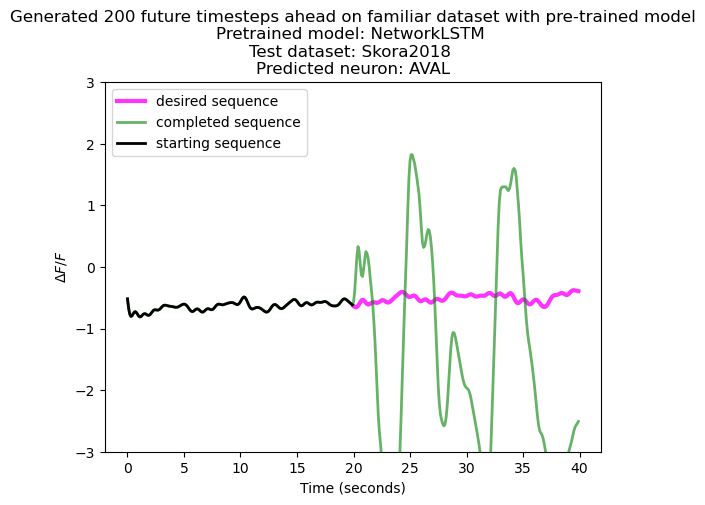

In [12]:
# Plot what the generations versus real data look like

plt.plot(
    time_in_seconds[future_time_slice],
    target[:, nidx],
    color="magenta",
    label="desired sequence",
    alpha=0.8,
    linewidth=3,
)

plt.plot(
    time_in_seconds[complete_time_slice],
    output[:, nidx],
    color="green",
    label="completed sequence",
    alpha=0.6,
    linewidth=2,
)

plt.plot(
    time_in_seconds[start_time_slice],
    input_[:, nidx],
    color="black",
    label="starting sequence",
    alpha=1.0,
    linewidth=2,
)

plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("$\Delta F / F$")
plt.ylim([-3.0, 3.0])
plt.title(
    "Generated %s future timesteps ahead on %s dataset with pre-trained model\nPretrained model: %s \nTest dataset: %s \nPredicted neuron: %s"
    % (
        new_timesteps,
        dataset_inclusion_str,
        model_name,
        test_dataset_name,
        neuron_name,
    )
)
plt.show()